In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# <font color="blue">DRTV, first five months</font>

first lets look at main figures of DRTV operation:
    

In [3]:
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT d1.month_,d1.total_spot,d1.total_lead,d1.contacted,d1.agreement,d2.donor,d2.avg_donation,d1.cost,d2.income
 FROM drtva.drtv_summary1 d1 join drtv_summary2 d2 where d1.month_=d2.month_ '''
cursor.execute(query)
result=cursor.fetchall()
df=DataFrame(result)
df.columns = [column[0] for column in cursor.description]
dbconn.close()
df



,month_,total_spot,total_lead,contacted,agreement,donor,avg_donation,cost,income
0,1,35,2683,1954,118,112,19.5,6828,16965
1,2,29,1796,1395,85,76,19.5,4968,11540
2,3,71,1377,1042,35,29,20.7,3288,4870
3,4,113,3407,2207,122,106,20.8,6911,16450
4,5,96,1420,798,55,41,20.7,2702,5970
5,Grand Total,344,10683,7396,415,364,20.1,24697,55795


<b>some notes:</b> <br>
month       : spot month <br>
contacted   : total number of tlfr 'reach_no' or 'reach_yes' belonging to the signers<br>
agreement   : total number of 'reach_yes' belonging to the signers of the spot<br>
debited     : total number of subscribers who paid at least once<br>
avg_amount  : avg payment amount of those debited<br>
cost        : total cost in the spot month<br>
income      : total amount of debited in the 12 month period following their fist payment_date,grouped acc their spot_date<br>
<br><br>

Now, lets check some indicatiors using this data: <br>

In [5]:
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT d1.month_,d1.total_lead,format(d1.contacted/d1.total_lead,2) as contact_rate,format(d1.agreement/d1.contacted,2) 
as agreement_rate,format(1-d2.donor/d1.agreement,2) as no_show,format(d1.cost/d1.total_lead,1) as cpl ,
format(d1.cost/d2.donor,0) as cpd,format(d2.income/d1.cost,2) as roi
 FROM drtva.drtv_summary1 d1 join drtv_summary2 d2 where d1.month_=d2.month_ '''
cursor.execute(query)
result=cursor.fetchall()
df1=DataFrame(result)
df1.columns = [column[0] for column in cursor.description]
dbconn.close()
df1

,month_,total_lead,contact_rate,agreement_rate,no_show,cpl,cpd,roi
0,1,2683,0.73,0.06,0.05,2.5,61,2.48
1,2,1796,0.78,0.06,0.11,2.8,65,2.32
2,3,1377,0.76,0.03,0.17,2.4,113,1.48
3,4,3407,0.65,0.06,0.13,2.0,65,2.38
4,5,1420,0.56,0.07,0.25,1.9,66,2.21
5,Grand Total,10683,0.69,0.06,0.12,2.3,68,2.26


here, <br>
<b>contact rate</b> is contacted/total_leads<br>
<b>agreement_rate</b> is agreement/contacted<br>
<b>no_show</b> is 1-debited/agreement<br><br><br>



<Container object of 5 artists>

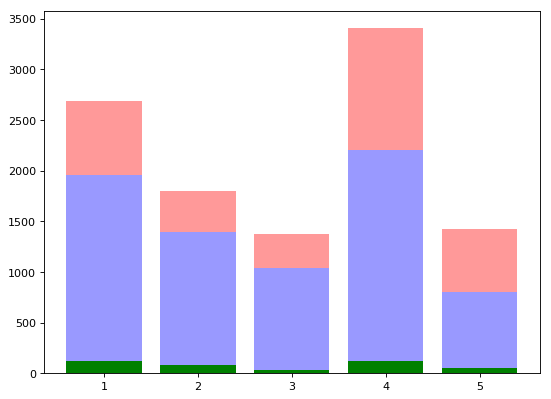

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(df.index[:5],df.total_leads[:5],tick_label=[1,2,3,4,5], facecolor='#ff9999', label='total_leads')
plt.bar(df.index[:5],df.contacted[:5],tick_label=[1,2,3,4,5], facecolor='#9999ff',label='contacted')
plt.bar(df.index[:5],df.agreement[:5],tick_label=[1,2,3,4,5], facecolor='green',label='agreement')


<font color="green">agreement</font><br>
<font color="blue">contacted addition</font> <br>
<font color="red">total leads addition</font> <br><br>


Let's look at closer to spot performance, I merged all data in one table like this:


,spot_id,tv_channel,spot_type,roi
0,1,F,X,NaN
1,2,E,X,7.3
2,3,F,X,NaN
3,4,B,X,2.2
4,5,E,X,4.1


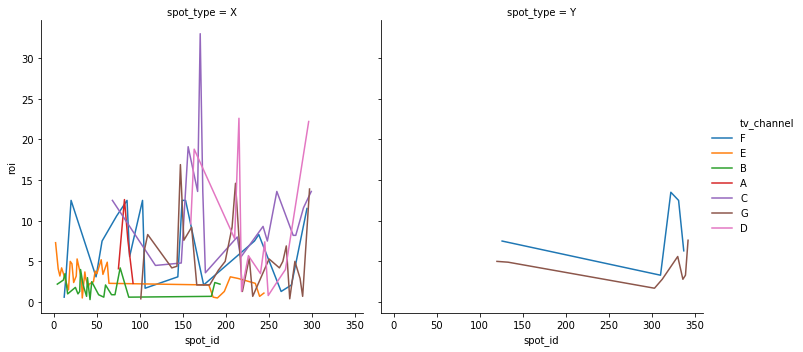

In [27]:
%matplotlib inline
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT spot_id,tv_channel,spot_type,format(income/spot_cost,1) as roi FROM drtva.drtv_summary3'''

cursor.execute(query)
result=cursor.fetchall()
df2=DataFrame(result)
df2.columns = [column[0] for column in cursor.description]
dbconn.close()
import seaborn as sns
df2['roi']=df2.roi.astype('float')
sns.relplot(x="spot_id", y="roi", 
            kind="line",hue="tv_channel",  col="spot_type",data=df2)
df2.head()

Using this table, I checked Spot Type X by channel:

In [48]:
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT tv_channel,count(spot_id),sum(spot_cost),sum(lead_count),sum(debited),sum(income),
format(sum(spot_cost)/sum(lead_count),1) as cost_per_lead,format(sum(spot_cost)/ sum(debited),0) as cost_per_debited,
format(sum(income)/sum(spot_cost),1) as income_vs_cost FROM drtva.drtv_summary3 where spot_type='X'
group by tv_channel
union 
SELECT 'Grand Total' as tv_channel,count(spot_id),sum(spot_cost),sum(lead_count),sum(debited),sum(income),
format(sum(spot_cost)/sum(lead_count),1) as cost_per_lead,format(sum(spot_cost)/ sum(debited),0) as cost_per_debited,
format(sum(income)/sum(spot_cost),1) as income_vs_cost FROM drtva.drtv_summary3  where spot_type='X' '''
cursor.execute(query)
result=cursor.fetchall()
df4=DataFrame(result)
df4.columns=['tv_channel','total_spot','cost','total_leads','total_debited','total_income','cost_per_lead','cost_per_debited','cost_vs_income']
dbconn.close()
df4

,tv_channel,total_spot,cost,total_leads,total_debited,total_income,cost_per_lead,cost_per_debited,cost_vs_income
0,A,22,726,916,7,875,0.8,104,1.2
1,B,25,7860,1668,78,12560,4.7,101,1.6
2,C,51,1126,286,22,4210,3.9,51,3.7
3,D,22,792,1278,27,3805,0.6,29,4.8
4,E,33,8663,4176,153,23670,2.1,57,2.7
5,F,85,2040,677,24,3135,3.0,85,1.5
6,G,48,1728,1122,38,5250,1.5,45,3.0
7,Grand Total,286,22935,10123,349,53505,2.3,66,2.3


And then Spot Type 'Y' : 

In [26]:
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT tv_channel,count(spot_id),sum(spot_cost),sum(lead_count),sum(debited),sum(income),
format(sum(spot_cost)/sum(lead_count),1) as cost_per_lead,format(sum(spot_cost)/ sum(debited),1) as cost_per_debited,
format(sum(income)/sum(spot_cost),1) as income_vs_cost FROM drtva.drtv_summary3 where spot_type='Y'
group by tv_channel
union 
SELECT 'Grand Total' as tv_channel,count(spot_id),sum(spot_cost),sum(lead_count),sum(debited),sum(income),
format(sum(spot_cost)/sum(lead_count),1) as cost_per_lead,format(sum(spot_cost)/ sum(debited),1) as cost_per_debited,
format(sum(income)/sum(spot_cost),1) as income_vs_cost FROM drtva.drtv_summary3  where spot_type='Y' '''
cursor.execute(query)
result=cursor.fetchall()
df5=DataFrame(result)
df5.columns=['tv_channel','total_spot','cost','total_leads','total_debited','total_income','cost_per_lead','cost_per_debited','cost_vs_income']
dbconn.close()
df5

,tv_channel,total_spot,cost,total_leads,total_debited,total_income,cost_per_lead,cost_per_debited,cost_vs_income
0,B,1,204,10,None,None,20.4,None,None
1,C,19,418,99,1,45,4.2,418.0,0.1
2,F,19,456,147,6,1035,3.1,76.0,2.3
3,G,19,684,304,8,1210,2.3,85.5,1.8
4,Grand Total,58,1762,560,15,2290,3.1,117.5,1.3


And when we look at distribution of leads in week days:

<BarContainer object of 7 artists>

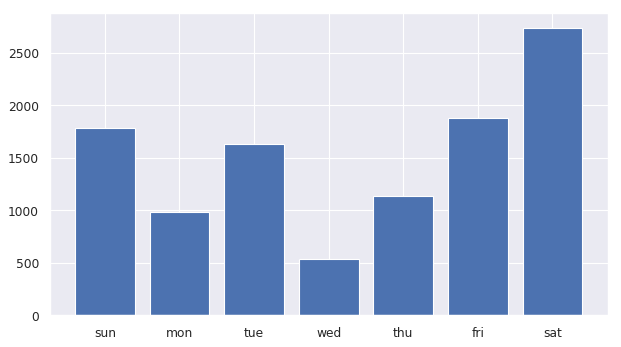

In [15]:
import mysql.connector
from pandas import DataFrame
dbconn= mysql.connector.connect(host='127.0.0.1',port=3306,database='drtva',user='root',password='sankie')
cursor=dbconn.cursor()
query='''
SELECT dayofweek(spot_date) as day_week,spot_id,lead_count, from  drtva.drtv_summary3 
group by day_week '''

cursor.execute(query)
result=cursor.fetchall()
df2=DataFrame(result)
df2.columns=['day_week','lead_count']
dbconn.close()


%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(9, 5), dpi=80)
plt.bar(df2.day_week,df2.lead_count,tick_label=['sun','mon','tue','wed','thu','fri','sat'])

<b>Findings for Spot Type X</b>

- Channel A brings relatively cheap leads, but they cannot converted into paying newsletter_subscribers
- Channel B is the worst since it is bringing leads is expensive, at the same time those leads cannot converted into paying subscribers.Spots are expensive but it doesn't pay back.
- Channel C has cheap spots,it doesn't bring enough leads,but still performance is ok. 
- Channel D is the best since it is bringing cheap leads and those leads could converted effectively to paying subscribers. Regular payments of these work also fine since income/cost efficiency is high.
- Channel E is also preferable. although spots are really expensive,its lead costs are below average,since it brings a lot of leads. income/cost ratio is ok, it pays back. 
- Channel F is the most used channel with 104 spots but leads are costly and doesn't pay back well
- Channel G is also ok, since cost_per lead and cost_per_debited is below average. 

<b>Findings for Spot Type Y</b>
- Type 'Y' i relatively new type compared to 'X' and has not spotted like 'X'.
- Channel C has a very bad performance in this type, wheras F worked well. 

<b>Conclusion</b>

- Channel A,B,F shouldn't be used for spot_type 'X',whereas C,D,E,G can have more spots. F can be used for type 'Y',  but not 'C'
 
- Saturday is a good day for lead generation

